In [63]:
from quat_routines import quaternion_product, quat2so3, quat2euler, conjugate, quat2rot, skew
import numpy as np

In [64]:
# parameters

m = 11.5
g = 9.8

W = m*g  # 112.7

length = 0.457
width = 0.338
height = 0.254
volume = length * width * height

density = 997
buoyancy_constant = 1
buoyancy = density*volume*buoyancy_constant # слишком мало для рова

B = 114.8  # непонятно откуда взялись эти данные, там 0.2*g + W

z_g = 0.02
r_g = np.array([0, 0, -z_g])

In [ ]:
density*g*volume # слишком много

383.34327689840006

https://bluerobotics.com/learn/buoyancy-calculator/

In [65]:
def R(X):
  q = X[3:]
  return quat2rot(q).T

def T(X):
  q = X[3:]
  p, e1, e2, e3 = q
  return 0.5*np.array([[-e1, -e2, -e3],
                         [p, -e3, e2],
                         [e3, p, -e1],
                         [-e2, e1, p]])


def J(X):
    return np.block([[R(X), np.zeros((3,3))], [np.zeros((4,3)), T(X)]])

In [66]:
# inertia for a box
I_0 = np.array([[width**2 + height**2, 0.001, 0.001],
                [0.001, height**2 + length**2, 0.001],
                [0.001, 0.001, length**2 + width**2]])
I_0 *= m / 12

M_rb = np.block([[m*np.eye(3), -m*skew(r_g)], [m*skew(r_g), I_0]])

M = M_rb
M_inv = np.linalg.inv(M)

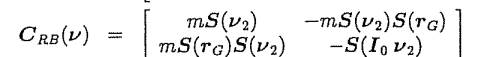

In [67]:
def C_rb(vel):
    v, w = vel[:3], vel[3:]
    return np.block([[m*skew(w), -m*skew(w)@skew(r_g)], [m*skew(w)@skew(r_g), -skew(I_0@w)]])

def C(v):
    return C_rb(v)

In [86]:
K_1 = np.diag([10, 10, 10, 0, 0, 0])  # коэффициенты взяты из головы
K_2 = np.diag([0.1, 0.1, 0.1, 0, 0, 0])  # коэффициенты взяты из головы

def D(vel):
    speed = np.linalg.norm(vel)

    D_lin = K_1
    D_quad = K_2*speed

    return D_lin + D_quad

In [70]:
def f_g(X):
  return -R(X).T@np.array([0, 0, W])

def f_b(X):
  return R(X).T@np.array([0, 0, B])

def g_(X):
    res = np.zeros((6, ))

    fg = f_g(X)
    fb = f_b(X)

    res[:3] = fg + fb
    res[3:] = np.cross(r_g, fg)
    return res

In [87]:
def f(X, t, u):
    x, v = X[:7], X[7:]

    q = x[3:]

    x[3:] = q/np.linalg.norm(q)

    dx = J(x)@v

    dv = -M_inv@(C(v)@v + D(v)@v + g_(x) - u)

    dX = dx.tolist()
    dX.extend(dv)

    return dX

### Simulation

In [91]:
from scipy.integrate import odeint


def simulate(f, control, X_0, X_d, t_0=0, t_f=30, N=1000):

    t = np.linspace(t_0, t_f, N)
    dT = (t_f - t_0)/N
    x_sol = []
    u_sol = []
    x0 = X_0
    u0 = np.array(control(x0, 0, X_d))

    x_sol = np.zeros((N, len(x0)))
    u_sol = np.zeros((N, len(u0)))

    for i in range(N):
        time = t[i]
        t_k = np.linspace(time, time+dT, 2)
        u = control(x0, time, X_d)
        x_k = odeint(f, x0, t_k, args=(u, ))
        x0 = x_k[-1]
        x_sol[i, :] = x0
        u_sol[i, :] = u

    return x_sol, u_sol, t

In [73]:
from matplotlib.pyplot import *


def plot_graphs(f, control, init_state, X_d):

    x_sol, u_sol, t = simulate(f, control, init_state, X_d)

    plot(t, x_sol[:, :3], label=['x', 'y', 'z'])

    ylabel(r'Output $y$')
    xlabel(r'Time $t$ (s)')
    grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
    legend(loc='lower right')
    grid(True)
    tight_layout()
    show()

    angles = [quat2euler(q) for q in x_sol[:, 3:7]]

    plot(t, angles, label=['phi', 'theta', 'psi'])

    ylabel(r'Output $y$')
    xlabel(r'Time $t$ (s)')
    grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
    legend(loc='lower right')
    grid(True)
    tight_layout()
    show()

    plot(t, x_sol[:, 7:], label=['dx', 'dy', 'dz', 'dphi', 'dtheta', 'dpsi'])

    ylabel(r'Output $dy$')
    xlabel(r'Time $t$ (s)')
    grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
    legend(loc='lower right')
    grid(True)
    tight_layout()
    show()

    plot(t, u_sol, label=['u_x', 'u_y', 'u_z', 'u_phi', 'u_theta', 'u_psi'])

    ylabel(r'Control $y$')
    xlabel(r'Time $t$ (s)')
    grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
    legend(loc='lower right')
    grid(True)
    tight_layout()
    show()

### Control

In [74]:
def zero_control(X, x_d, t):
    return [0, 0, 0, 0, 0, 0]

In [75]:
!pip install simple_pid

In [76]:
from simple_pid import PID


def so3_error(quaternion, desired_quaternion):
    conjugated_quaternion = conjugate(quaternion)
    q_err = quaternion_product(desired_quaternion, conjugated_quaternion)
    so3_error = quat2so3(q_err)
    return so3_error


pids = [PID(1, 0.001, 0.0),
        PID(1, 0.001, 0.0),
        PID(1.2, 0.001, 0.0)]

p_gain = np.diag([3, 2, 5])
d_gain = np.diag([2, 1, 3])


def pd_torque(x, x_d, v):

    tau = []

    for i in range(3):
        tau.append(pids[i](x[i]))

    orientation_error = so3_error(x[3:], x_d[3:])
    omega = np.array(v[3:])
    body_torque = p_gain @ orientation_error - d_gain @ omega
    tau.extend(body_torque)

    return tau

In [78]:
L = 1


def model_based_pid(X, t, x_d):

    x, v = X[:7], X[7:]

    e_b = J(x).T@(np.array(x) - np.array(x_d))
    v_r = L*e_b
    a_r = -L*np.array(v)

    tau_m = M@a_r + C(v)@v + D(v)@v_r + g_(x)
    tau_pid = M@pd_torque(x, x_d, v)

    return tau_pid + tau_m

In [79]:
X_0 = [1, -1, -1.5, 0.9238795, 0, 0, 0.3826834,  1, 0, 0, 0, 0, 0]

X_d = [0.5, -0.7, -0.5, 1, 0, 0, 0]

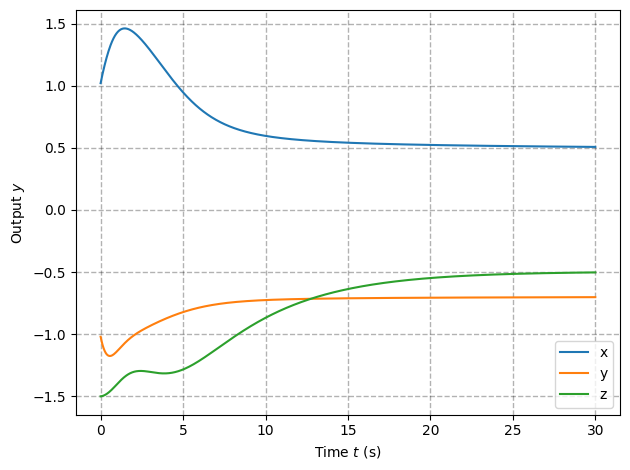

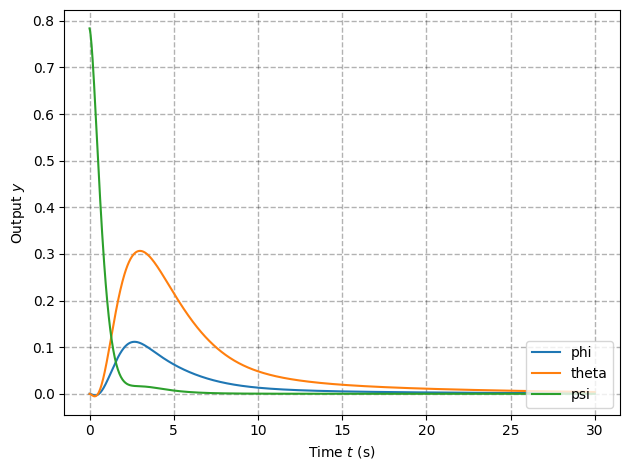

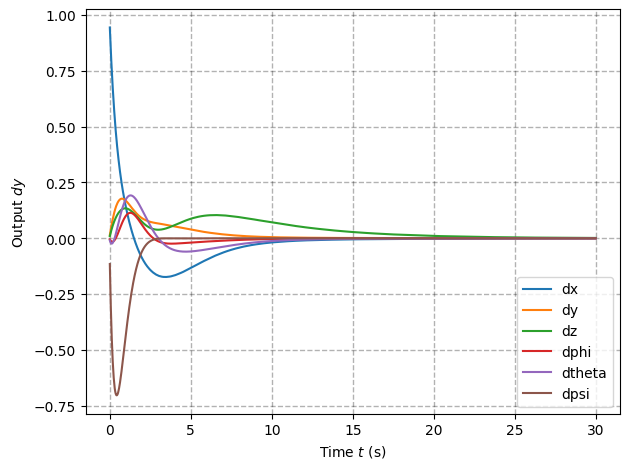

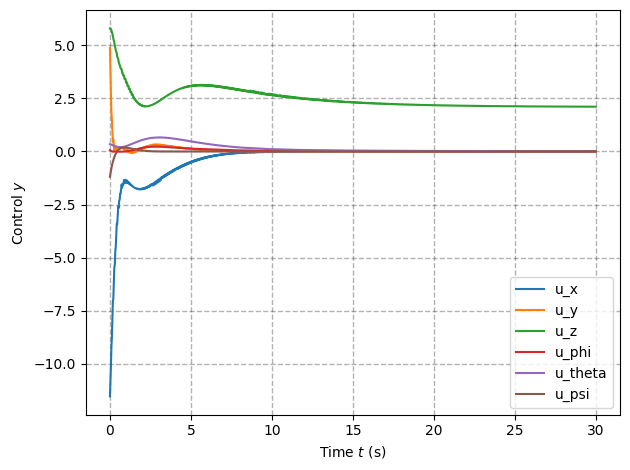

In [92]:
for i in range(3):
        pids[i].reset()
        pids[i].setpoint = X_d[i]

plot_graphs(f, model_based_pid, X_0, X_d)